PyTorch: 2.5.1+cu121
CUDA: True
GPU: NVIDIA RTX 6000 Ada Generation

ANÁLISIS DE DATOS

--------------------------------TRAIN---------------------------------
Total: 588 imágenes
  Major Defect        :  181 ( 30.8%)
  Minor Defect        :  204 ( 34.7%)
  No Defect           :  203 ( 34.5%)

------------------------------VALIDATION------------------------------
Total: 195 imágenes
  Major Defect        :   60 ( 30.8%)
  Minor Defect        :   68 ( 34.9%)
  No Defect           :   67 ( 34.4%)

-----------------------------TEST PUBLIC------------------------------
Total: 97 imágenes

-----------------------------TEST PRIVATE-----------------------------
Total: 102 imágenes

Class weights para loss: [1.082873  0.9607843 0.9655172]
Batches por epoch: 37

MODELO: EfficientNet-V2-S + CBAM
Parámetros totales: 21,173,254
Parámetros entrenables: 21,173,254
Memoria estimada: ~80.8 MB

Optimizer: AdamW con LR diferenciado
  Backbone LR: 2.9999999999999997e-05
  Classifier LR: 0.0003
Loss: Focal

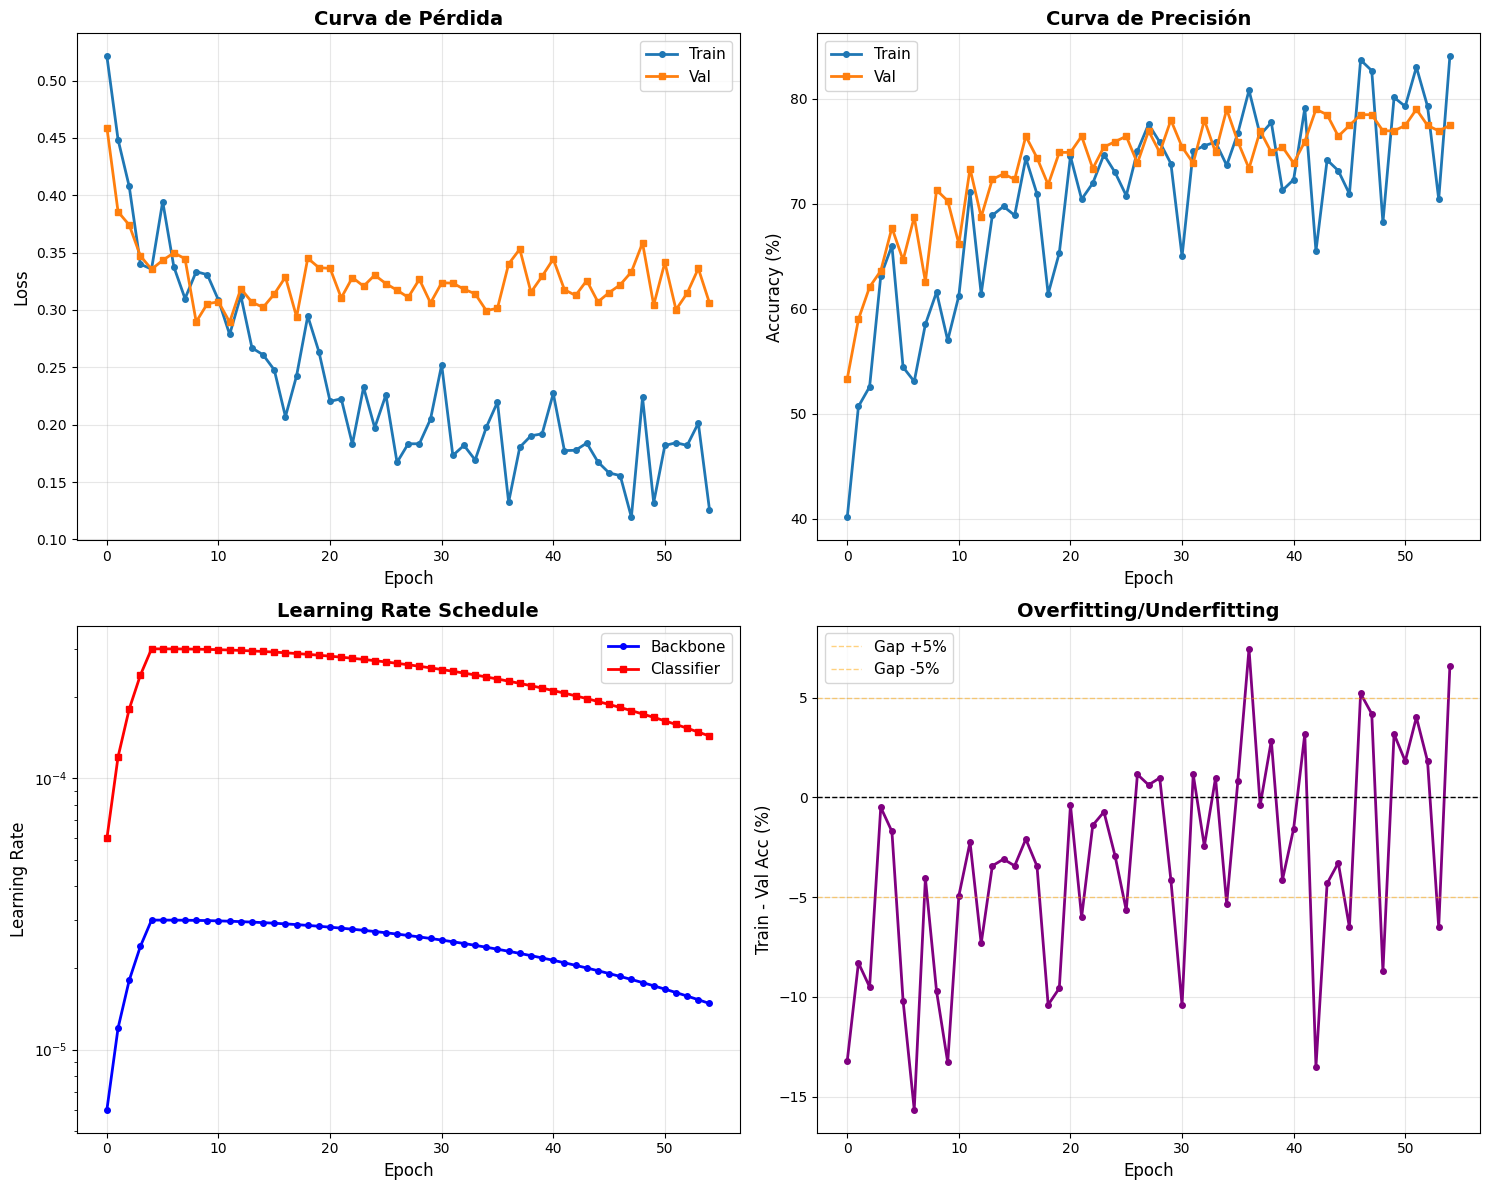

✓ Gráficas guardadas: training_curves.png

EVALUACIÓN EN TEST PÚBLICO

Test Loss: 0.1957
Test Accuracy: 81.44%

Reporte de Clasificación:
              precision    recall  f1-score   support

Major Defect     0.9062    0.9667    0.9355        30
Minor Defect     0.8400    0.6176    0.7119        34
   No Defect     0.7250    0.8788    0.7945        33

    accuracy                         0.8144        97
   macro avg     0.8237    0.8210    0.8140        97
weighted avg     0.8214    0.8144    0.8091        97


-------------------------Métricas Detalladas--------------------------

Major Defect:
  Precision: 0.9062
  Recall:    0.9667
  F1-Score:  0.9355
  Support:   30

Minor Defect:
  Precision: 0.8400
  Recall:    0.6176
  F1-Score:  0.7119
  Support:   34

No Defect:
  Precision: 0.7250
  Recall:    0.8788
  F1-Score:  0.7945
  Support:   33


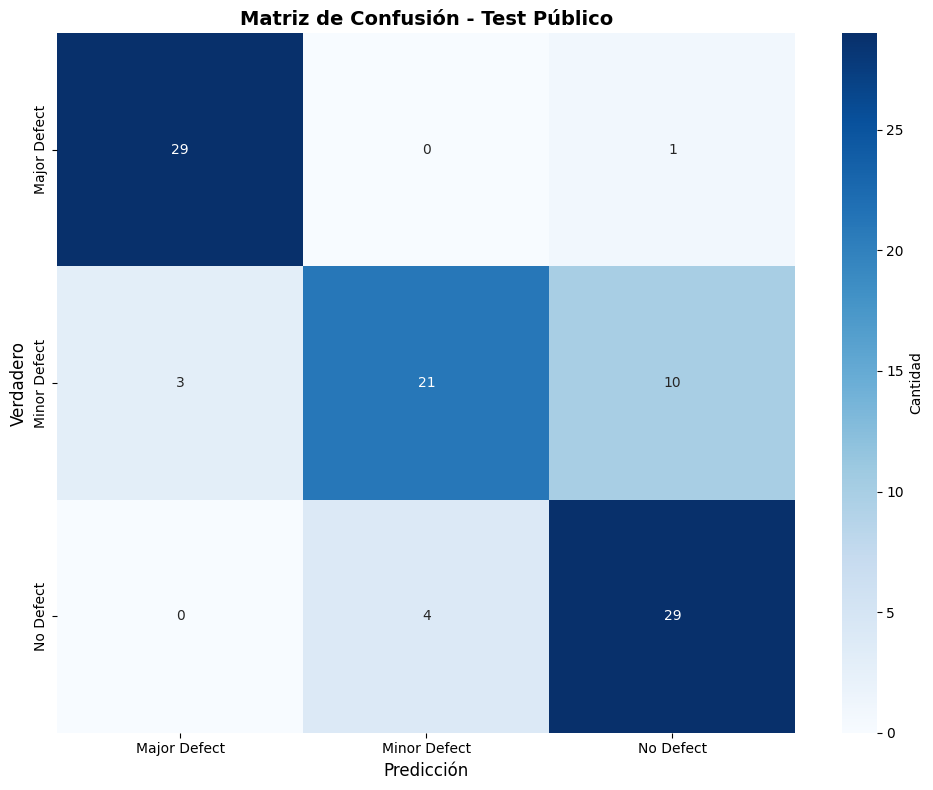


✓ Matriz de confusión guardada: confusion_matrix_test_public.png

PREDICCIÓN EN TEST PRIVADO

  Procesadas: 100/102
✓ Predicciones completadas: 102 imágenes

RESULTADOS GUARDADOS
Archivo: resultados_predicciones.xlsx
Total predicciones: 102

Distribución de clases predichas:
Target
No Defect       43
Major Defect    30
Minor Defect    29
Name: count, dtype: int64

Estadísticas de Confianza:
  Media:   70.04%
  Mediana: 72.08%
  Std Dev: 12.96%
  Mínima:  35.37%
  Máxima:  91.41%

Primeras 10 predicciones:
      ID       Target Precision  Confidence_Score Prob_Major_Defect Prob_Minor_Defect Prob_No_Defect
IMG_0000 Major Defect    76.27%         76.271075            76.27%            11.70%         12.03%
IMG_0001 Major Defect    82.13%         82.127297            82.13%             5.39%         12.49%
IMG_0002 Major Defect    55.20%         55.198717            55.20%            12.22%         32.58%
IMG_0003 Major Defect    38.19%         38.191310            38.19%            33.15

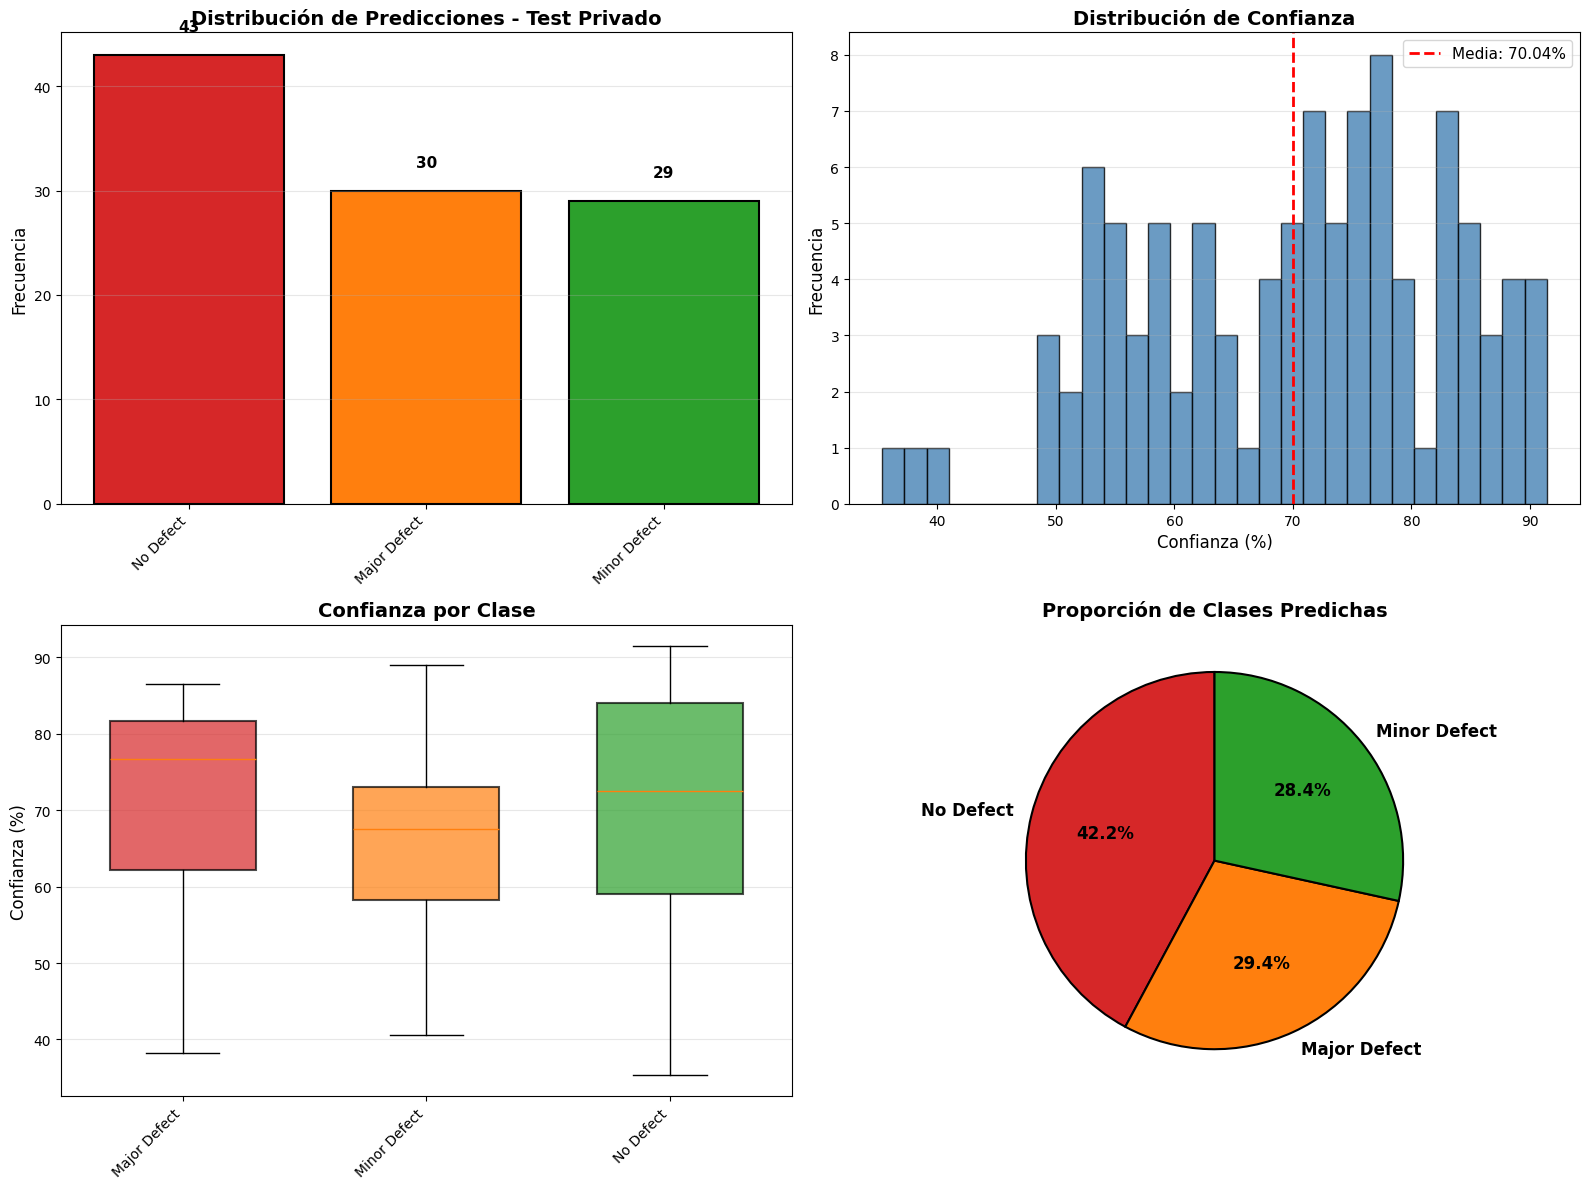

✓ Distribución de predicciones guardada: predictions_distribution.png

ARCHIVOS GENERADOS
✓ Modelo:                    best_model.pth
✓ Predicciones:              resultados_predicciones.xlsx
✓ Resumen entrenamiento:     training_summary.json
✓ Historia entrenamiento:    training_history.csv
✓ Curvas entrenamiento:      training_curves.png
✓ Matriz confusión:          confusion_matrix_test_public.png
✓ Distribución predicciones: predictions_distribution.png

RESUMEN FINAL
Mejor Val Accuracy:    78.97%
Test Public Accuracy:  81.44%
Epochs entrenados:     55
Predicciones totales:  102
Confianza media:       70.04%

✅ PROCESO COMPLETADO EXITOSAMENTE! ✅



In [3]:
# ============================================================================
# DETECCIÓN DE DEFECTOS EN GRANADAS - SOLUCIÓN ROBUSTA Y OPTIMIZADA
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import random
import json
import warnings
import copy
from collections import Counter
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================================================
# CONFIGURACIÓN
# ============================================================================

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

class Config:
    SEED = 42
    BASE_PATH = 'pomegranate_split_free'
    TRAIN_PATH = os.path.join(BASE_PATH, 'train')
    VAL_PATH = os.path.join(BASE_PATH, 'val')
    TEST_PUBLIC_PATH = os.path.join(BASE_PATH, 'test_public')
    TEST_PRIVATE_PATH = os.path.join(BASE_PATH, 'test_private')
    
    CLASS_NAMES = ['Major Defect', 'Minor Defect', 'No Defect']
    CLASS_TO_IDX = {'Major Defect': 0, 'Minor Defect': 1, 'No Defect': 2}
    IDX_TO_CLASS = {0: 'Major Defect', 1: 'Minor Defect', 2: 'No Defect'}
    
    BATCH_SIZE = 16
    NUM_EPOCHS = 100
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-4
    IMG_SIZE = 224
    NUM_CLASSES = 3
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    WARMUP_EPOCHS = 5
    PATIENCE = 20
    MIN_DELTA = 0.001
    
    RESULTS_PATH = 'resultados_predicciones.xlsx'
    MODEL_PATH = 'best_model.pth'

config = Config()

# ============================================================================
# DATASET CON ANÁLISIS Y VALIDACIÓN
# ============================================================================

class PomegranateDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.samples = []
        self.class_distribution = Counter()
        
        if is_test:
            if os.path.exists(root_dir):
                for img_name in sorted(os.listdir(root_dir)):
                    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                        img_path = os.path.join(root_dir, img_name)
                        if self._validate_image(img_path):
                            self.samples.append((img_path, -1, img_name))
        else:
            for class_name in config.CLASS_NAMES:
                class_path = os.path.join(root_dir, class_name)
                if os.path.exists(class_path):
                    class_idx = config.CLASS_TO_IDX[class_name]
                    for img_name in sorted(os.listdir(class_path)):
                        if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                            img_path = os.path.join(class_path, img_name)
                            if self._validate_image(img_path):
                                self.samples.append((img_path, class_idx, img_name))
                                self.class_distribution[class_idx] += 1
    
    def _validate_image(self, img_path):
        try:
            img = Image.open(img_path)
            img.verify()
            return True
        except:
            print(f"⚠ Imagen corrupta: {img_path}")
            return False
    
    def get_labels(self):
        return [label for _, label, _ in self.samples]
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label, img_name = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error cargando {img_path}: {e}")
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), (128, 128, 128))
        
        if self.transform:
            image = self.transform(image)
        
        return (image, img_name) if self.is_test else (image, label)

# ============================================================================
# AUGMENTACIONES AVANZADAS
# ============================================================================

class RandAugment:
    def __init__(self, n=2, m=9):
        self.n = n
        self.m = m
        self.augment_list = [
            transforms.RandomRotation(30),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.3),
            transforms.ColorJitter(contrast=0.3),
            transforms.ColorJitter(saturation=0.3),
        ]
    
    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op in ops:
            img = op(img)
        return img

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(config.IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    RandAugment(n=2, m=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(config.IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# ============================================================================
# CARGAR Y ANALIZAR DATASETS
# ============================================================================

train_dataset = PomegranateDataset(config.TRAIN_PATH, transform=train_transform)
val_dataset = PomegranateDataset(config.VAL_PATH, transform=val_test_transform)
test_public_dataset = PomegranateDataset(config.TEST_PUBLIC_PATH, transform=val_test_transform)
test_private_dataset = PomegranateDataset(config.TEST_PRIVATE_PATH, transform=val_test_transform, is_test=True)

train_labels = train_dataset.get_labels()
val_labels = val_dataset.get_labels()

print(f"\n{'='*70}")
print("ANÁLISIS DE DATOS")
print(f"{'='*70}")

print(f"\n{'TRAIN':-^70}")
print(f"Total: {len(train_dataset)} imágenes")
for class_idx, class_name in config.IDX_TO_CLASS.items():
    count = train_labels.count(class_idx)
    pct = 100 * count / len(train_dataset)
    print(f"  {class_name:20s}: {count:4d} ({pct:5.1f}%)")

print(f"\n{'VALIDATION':-^70}")
print(f"Total: {len(val_dataset)} imágenes")
for class_idx, class_name in config.IDX_TO_CLASS.items():
    count = val_labels.count(class_idx)
    pct = 100 * count / len(val_dataset)
    print(f"  {class_name:20s}: {count:4d} ({pct:5.1f}%)")

print(f"\n{'TEST PUBLIC':-^70}")
print(f"Total: {len(test_public_dataset)} imágenes")

print(f"\n{'TEST PRIVATE':-^70}")
print(f"Total: {len(test_private_dataset)} imágenes")
print(f"{'='*70}\n")

# Calcular class weights para balanceo
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)
class_weights_loss = torch.FloatTensor([total_samples / (len(class_counts) * count) for count in class_counts]).to(config.DEVICE)
print(f"Class weights para loss: {class_weights_loss.cpu().numpy()}")

# Weighted Random Sampler
sample_weights = [class_weights_loss[label].item() for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# ============================================================================
# DATALOADERS
# ============================================================================

def worker_init_fn(worker_id):
    np.random.seed(config.SEED + worker_id)
    random.seed(config.SEED + worker_id)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True,
    worker_init_fn=worker_init_fn,
    
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    
)

test_public_loader = DataLoader(
    test_public_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_private_loader = DataLoader(
    test_private_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

print(f"Batches por epoch: {len(train_loader)}\n")

# ============================================================================
# MODELO: EFFICIENTNET-V2-S CON CBAM
# ============================================================================

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return x * self.fc(x)

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
        )
        
    def forward(self, x):
        max_pool = torch.max(x, dim=1, keepdim=True)[0]
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        spatial = torch.cat([max_pool, avg_pool], dim=1)
        spatial_att = torch.sigmoid(self.spatial_attention(spatial))
        
        channel_att = torch.sigmoid(self.channel_attention(x))
        
        return x * channel_att * spatial_att

class EfficientNetV2Classifier(nn.Module):
    def __init__(self, num_classes=3, pretrained=True, use_cbam=True):
        super().__init__()
        
        self.backbone = models.efficientnet_v2_s(pretrained=pretrained)
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        self.cbam = CBAM(in_features) if use_cbam else nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone.features(x)
        features = self.backbone.avgpool(features)
        features = torch.flatten(features, 1)
        
        features = features.unsqueeze(-1).unsqueeze(-1)
        features = self.cbam(features)
        features = features.squeeze(-1).squeeze(-1)
        
        return self.classifier(features)

# ============================================================================
# CREAR MODELO
# ============================================================================

model = EfficientNetV2Classifier(
    num_classes=config.NUM_CLASSES,
    pretrained=True,
    use_cbam=True
).to(config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{'='*70}")
print("MODELO: EfficientNet-V2-S + CBAM")
print(f"{'='*70}")
print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Memoria estimada: ~{total_params * 4 / (1024**2):.1f} MB")
print(f"{'='*70}\n")

# ============================================================================
# LOSS, OPTIMIZER, SCHEDULER
# ============================================================================

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss(alpha=class_weights_loss, gamma=2.0)

backbone_params = []
classifier_params = []
for name, param in model.named_parameters():
    if 'backbone' in name:
        backbone_params.append(param)
    else:
        classifier_params.append(param)

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': config.LEARNING_RATE * 0.1},
    {'params': classifier_params, 'lr': config.LEARNING_RATE}
], weight_decay=config.WEIGHT_DECAY)

def warmup_lambda(epoch):
    if epoch < config.WARMUP_EPOCHS:
        return (epoch + 1) / config.WARMUP_EPOCHS
    return 1.0

warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)

cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.NUM_EPOCHS - config.WARMUP_EPOCHS,
    eta_min=1e-6
)

scaler = GradScaler()

print(f"Optimizer: AdamW con LR diferenciado")
print(f"  Backbone LR: {config.LEARNING_RATE * 0.1}")
print(f"  Classifier LR: {config.LEARNING_RATE}")
print(f"Loss: Focal Loss (gamma=2.0)")
print(f"Scheduler: Warmup ({config.WARMUP_EPOCHS} epochs) + Cosine Annealing\n")

# ============================================================================
# MIXUP AUGMENTATION
# ============================================================================

def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ============================================================================
# TRAINING & VALIDATION
# ============================================================================

class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_acc):
        score = val_acc
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def train_epoch(model, loader, criterion, optimizer, scheduler, scaler, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        
        use_mixup = epoch >= config.WARMUP_EPOCHS and np.random.rand() < 0.5
        
        optimizer.zero_grad()
        
        with autocast():
            if use_mixup:
                images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=0.4)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if (batch_idx + 1) % 10 == 0:
            curr_loss = running_loss / total
            curr_acc = 100. * correct / total
            print(f"  [{batch_idx+1:3d}/{len(loader)}] Loss: {curr_loss:.4f} | Acc: {curr_acc:.2f}%", end='\r')
    
    if epoch < config.WARMUP_EPOCHS:
        warmup_scheduler.step()
    else:
        cosine_scheduler.step()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            running_loss += loss.item() * images.size(0)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

# ============================================================================
# TRAINING LOOP
# ============================================================================

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr_backbone': [], 'lr_classifier': []
}

best_val_acc = 0.0
best_model_wts = None
early_stopping = EarlyStopping(patience=config.PATIENCE, min_delta=config.MIN_DELTA)

print(f"{'='*70}")
print("INICIO DEL ENTRENAMIENTO")
print(f"{'='*70}\n")

for epoch in range(config.NUM_EPOCHS):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"{'='*70}")
    
    lr_backbone = optimizer.param_groups[0]['lr']
    lr_classifier = optimizer.param_groups[1]['lr']
    print(f"LR Backbone: {lr_backbone:.6f} | LR Classifier: {lr_classifier:.6f}")
    
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer,
        warmup_scheduler if epoch < config.WARMUP_EPOCHS else cosine_scheduler,
        scaler, config.DEVICE, epoch
    )
    
    val_loss, val_acc, val_preds, val_labels, val_probs = validate_epoch(
        model, val_loader, criterion, config.DEVICE
    )
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr_backbone'].append(lr_backbone)
    history['lr_classifier'].append(lr_classifier)
    
    print(f"\n{'-'*70}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"{'-'*70}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history,
            'config': vars(config)
        }, config.MODEL_PATH)
        
        print(f"✓ MEJOR MODELO GUARDADO (Val Acc: {val_acc:.2f}%)")
    else:
        print(f"  Mejor Val Acc: {best_val_acc:.2f}%")
    
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print(f"\n{'='*70}")
        print(f"EARLY STOPPING en epoch {epoch+1}")
        print(f"Mejor Val Acc: {best_val_acc:.2f}%")
        print(f"{'='*70}")
        break

print(f"\n{'='*70}")
print("ENTRENAMIENTO COMPLETADO")
print(f"{'='*70}")
print(f"Mejor Val Acc: {best_val_acc:.2f}%")
print(f"{'='*70}\n")

# ============================================================================
# VISUALIZACIONES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(history['train_loss'], 'o-', label='Train', linewidth=2, markersize=4)
axes[0, 0].plot(history['val_loss'], 's-', label='Val', linewidth=2, markersize=4)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Curva de Pérdida', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_acc'], 'o-', label='Train', linewidth=2, markersize=4)
axes[0, 1].plot(history['val_acc'], 's-', label='Val', linewidth=2, markersize=4)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Curva de Precisión', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history['lr_backbone'], 'o-', label='Backbone', linewidth=2, markersize=4, color='blue')
axes[1, 0].plot(history['lr_classifier'], 's-', label='Classifier', linewidth=2, markersize=4, color='red')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

gap = np.array(history['train_acc']) - np.array(history['val_acc'])
axes[1, 1].plot(gap, 'o-', linewidth=2, color='purple', markersize=4)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].axhline(y=5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Gap +5%')
axes[1, 1].axhline(y=-5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Gap -5%')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Train - Val Acc (%)', fontsize=12)
axes[1, 1].set_title('Overfitting/Underfitting', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráficas guardadas: training_curves.png\n")

# ============================================================================
# EVALUACIÓN EN TEST PÚBLICO
# ============================================================================

checkpoint = torch.load(config.MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"{'='*70}")
print("EVALUACIÓN EN TEST PÚBLICO")
print(f"{'='*70}\n")

test_loss, test_acc, test_preds, test_labels, test_probs = validate_epoch(
    model, test_public_loader, criterion, config.DEVICE
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%\n")

print("Reporte de Clasificación:")
print(classification_report(
    test_labels, test_preds,
    target_names=config.CLASS_NAMES,
    digits=4
))

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, average=None, labels=[0, 1, 2]
)

print(f"\n{'Métricas Detalladas':-^70}")
for i, class_name in enumerate(config.CLASS_NAMES):
    print(f"\n{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print(f"  Support:   {support[i]}")

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=config.CLASS_NAMES,
    yticklabels=config.CLASS_NAMES,
    cbar_kws={'label': 'Cantidad'}
)
plt.ylabel('Verdadero', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.title('Matriz de Confusión - Test Público', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_test_public.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Matriz de confusión guardada: confusion_matrix_test_public.png\n")

# ============================================================================
# PREDICCIÓN EN TEST PRIVADO
# ============================================================================

print(f"{'='*70}")
print("PREDICCIÓN EN TEST PRIVADO")
print(f"{'='*70}\n")

model.eval()
private_predictions = []

with torch.no_grad():
    for batch_idx, (images, img_names) in enumerate(test_private_loader):
        images = images.to(config.DEVICE)
        
        with autocast():
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
        
        confidences, predicted = torch.max(probs, 1)
        
        for img_name, pred, conf, prob in zip(img_names, predicted, confidences, probs):
            img_id = os.path.splitext(img_name)[0]
            pred_class = config.IDX_TO_CLASS[pred.item()]
            conf_score = conf.item() * 100
            
            private_predictions.append({
                'ID': img_id,
                'Target': pred_class,
                'Precision': f"{conf_score:.2f}%",
                'Confidence_Score': conf_score,
                'Prob_Major_Defect': f"{prob[0].item()*100:.2f}%",
                'Prob_Minor_Defect': f"{prob[1].item()*100:.2f}%",
                'Prob_No_Defect': f"{prob[2].item()*100:.2f}%"
            })
        
        if (batch_idx + 1) % 50 == 0:
            print(f"  Procesadas: {batch_idx + 1}/{len(test_private_loader)}", end='\r')

print(f"\n✓ Predicciones completadas: {len(private_predictions)} imágenes\n")

# ============================================================================
# GUARDAR RESULTADOS EN EXCEL
# ============================================================================

df_predictions = pd.DataFrame(private_predictions)
df_predictions = df_predictions.sort_values('ID').reset_index(drop=True)

with pd.ExcelWriter(config.RESULTS_PATH, engine='openpyxl') as writer:
    df_predictions.to_excel(writer, index=False, sheet_name='Predicciones')
    
    worksheet = writer.sheets['Predicciones']
    
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                cell_length = len(str(cell.value))
                if cell_length > max_length:
                    max_length = cell_length
            except:
                pass
        adjusted_width = min(max_length + 3, 50)
        worksheet.column_dimensions[column_letter].width = adjusted_width

print(f"{'='*70}")
print("RESULTADOS GUARDADOS")
print(f"{'='*70}")
print(f"Archivo: {config.RESULTS_PATH}")
print(f"Total predicciones: {len(df_predictions)}")
print(f"\nDistribución de clases predichas:")
print(df_predictions['Target'].value_counts())
print(f"\nEstadísticas de Confianza:")
print(f"  Media:   {df_predictions['Confidence_Score'].mean():.2f}%")
print(f"  Mediana: {df_predictions['Confidence_Score'].median():.2f}%")
print(f"  Std Dev: {df_predictions['Confidence_Score'].std():.2f}%")
print(f"  Mínima:  {df_predictions['Confidence_Score'].min():.2f}%")
print(f"  Máxima:  {df_predictions['Confidence_Score'].max():.2f}%")
print(f"{'='*70}\n")

print("Primeras 10 predicciones:")
print(df_predictions.head(10).to_string(index=False))
print()

# ============================================================================
# VISUALIZACIÓN DE DISTRIBUCIÓN DE PREDICCIONES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors = ['#d62728', '#ff7f0e', '#2ca02c']
class_counts_pred = df_predictions['Target'].value_counts()

axes[0, 0].bar(range(len(class_counts_pred)), class_counts_pred.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_xticks(range(len(class_counts_pred)))
axes[0, 0].set_xticklabels(class_counts_pred.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Frecuencia', fontsize=12)
axes[0, 0].set_title('Distribución de Predicciones - Test Privado', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

for i, (label, value) in enumerate(class_counts_pred.items()):
    axes[0, 0].text(i, value + 2, str(value), ha='center', va='bottom', fontweight='bold', fontsize=11)

axes[0, 1].hist(df_predictions['Confidence_Score'], bins=30, color='steelblue', edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel('Confianza (%)', fontsize=12)
axes[0, 1].set_ylabel('Frecuencia', fontsize=12)
axes[0, 1].set_title('Distribución de Confianza', fontsize=14, fontweight='bold')
mean_conf = df_predictions['Confidence_Score'].mean()
axes[0, 1].axvline(mean_conf, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_conf:.2f}%')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(axis='y', alpha=0.3)

confidence_by_class = []
labels_box = []
for class_name in config.CLASS_NAMES:
    class_data = df_predictions[df_predictions['Target'] == class_name]['Confidence_Score']
    if len(class_data) > 0:
        confidence_by_class.append(class_data)
        labels_box.append(class_name)

bp = axes[1, 0].boxplot(confidence_by_class, labels=labels_box, patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(1.5)

axes[1, 0].set_ylabel('Confianza (%)', fontsize=12)
axes[1, 0].set_title('Confianza por Clase', fontsize=14, fontweight='bold')
axes[1, 0].set_xticklabels(labels_box, rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].pie(
    class_counts_pred.values,
    labels=class_counts_pred.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)
axes[1, 1].set_title('Proporción de Clases Predichas', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('predictions_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribución de predicciones guardada: predictions_distribution.png\n")

# ============================================================================
# GUARDAR INFORMACIÓN DEL ENTRENAMIENTO
# ============================================================================

training_summary = {
    'model': 'EfficientNet-V2-S + CBAM',
    'total_params': total_params,
    'trainable_params': trainable_params,
    'best_val_acc': float(best_val_acc),
    'test_public_acc': float(test_acc),
    'epochs_trained': len(history['train_loss']),
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'weight_decay': config.WEIGHT_DECAY,
    'optimizer': 'AdamW (differential LR)',
    'loss_function': 'Focal Loss',
    'scheduler': 'Warmup + Cosine Annealing',
    'augmentation': 'RandAugment + Mixup',
    'predictions_summary': {
        'total': len(df_predictions),
        'mean_confidence': float(df_predictions['Confidence_Score'].mean()),
        'std_confidence': float(df_predictions['Confidence_Score'].std()),
        'distribution': df_predictions['Target'].value_counts().to_dict()
    }
}

with open('training_summary.json', 'w', encoding='utf-8') as f:
    json.dump(training_summary, f, indent=4, ensure_ascii=False)

history_df = pd.DataFrame(history)
history_df.to_csv('training_history.csv', index=False)

print(f"{'='*70}")
print("ARCHIVOS GENERADOS")
print(f"{'='*70}")
print(f"✓ Modelo:                    {config.MODEL_PATH}")
print(f"✓ Predicciones:              {config.RESULTS_PATH}")
print(f"✓ Resumen entrenamiento:     training_summary.json")
print(f"✓ Historia entrenamiento:    training_history.csv")
print(f"✓ Curvas entrenamiento:      training_curves.png")
print(f"✓ Matriz confusión:          confusion_matrix_test_public.png")
print(f"✓ Distribución predicciones: predictions_distribution.png")
print(f"{'='*70}\n")

print(f"{'='*70}")
print("RESUMEN FINAL")
print(f"{'='*70}")
print(f"Mejor Val Accuracy:    {best_val_acc:.2f}%")
print(f"Test Public Accuracy:  {test_acc:.2f}%")
print(f"Epochs entrenados:     {len(history['train_loss'])}")
print(f"Predicciones totales:  {len(df_predictions)}")
print(f"Confianza media:       {df_predictions['Confidence_Score'].mean():.2f}%")
print(f"{'='*70}\n")

print("✅ PROCESO COMPLETADO EXITOSAMENTE! ✅\n")